In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(ROOT_DIR)

from utils.utils import mse

from utils.problem import MitsubaProblem
from utils.problems.bunny import BunniesProblem

from utils.global_opt.boleap import BOLeap
from utils.global_opt.grad import GlobalOptGrad, RandomStartGrad
from utils.global_opt.utils import IterationStoppingCriteria, NotImprovingStoppingCriteria

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

mi.set_variant('cuda_ad_rgb')

In [2]:
single_bunny_pb = BunniesProblem(nb_bunnies=1, colored=False)

In [3]:
img_ref, bm_ref = single_bunny_pb.render(seed=0, spp=1024)
bm_ref

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [4]:
loss_fn = lambda img: mse(img, img_ref)
global_opt_grad = GlobalOptGrad(single_bunny_pb)
random_start_grad = RandomStartGrad(single_bunny_pb)
boleap_opt = BOLeap(single_bunny_pb)

In [5]:
def plot_final_result(best_ind, losses: dict, pb: MitsubaProblem, title=None):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    axs[0].imshow(pb.render_individual(best_ind, spp=1024)[1])
    axs[0].axis('off')
    axs[0].set_title('Optimized image')

    axs[1].imshow(bm_ref)
    axs[1].axis('off')
    axs[1].set_title('Reference Image')
    
    # plot loss
    for name, loss in losses.items():
        axs[2].plot(loss, label=name)
    axs[2].set_title('Loss')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Loss')

    if title is not None:
        fig.suptitle(title, fontsize=16)

    plt.legend()
    plt.show()

In [18]:
def random_start_exp(pop_size, grad_steps, seed=0):
    res, losses, nb_renderings = random_start_grad.run(
        loss_fn,
        pop_size=pop_size,
        grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=grad_steps),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {f"{i}" : losses[i] for i in range(len(losses))}
    plot_final_result(res.X, losses_dict, single_bunny_pb, title=f'Random start: {pop_size=}, {grad_steps=} - {nb_renderings=}')

In [16]:
def ga_grad_exp(pop_size, n_gen, grad_steps, seed=0):
    res, losses, nb_renderings = global_opt_grad.run(
        GA(pop_size=pop_size, eliminate_duplicates=True),
        loss_fn,
        n_gen=n_gen,
        grad_descent_stopping_criteria=IterationStoppingCriteria(grad_steps),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {
        "avg" : [np.mean(l) for l in losses],
        "best" : [np.min(l) for l in losses],
        "worst" : [np.max(l) for l in losses],
    }
    plot_final_result(res.X, losses_dict, single_bunny_pb, title=f'Genetic algorithm: {pop_size=}, {n_gen=}, {grad_steps=}  - {nb_renderings=}')

In [17]:
def boleap_exp(pop_size, bo_steps, cmaes_steps, grad_steps, seed=0):
    best_ind, losses, nb_renderings = boleap_opt.run(
        loss_fn,
        bo_steps,
        cmaes_steps,
        grad_steps,
        pop_size=pop_size,
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {"grad" : losses}
    plot_final_result(best_ind, losses_dict, single_bunny_pb, title=f'BO-Leap: {pop_size=}, {bo_steps=}, {cmaes_steps=}, {grad_steps=}  - {nb_renderings=}')

# Gradient descent from 1 random starting point


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Ind. 1/1] Grad step 199	Best loss: 0.002679	Nb renderings: 199: : 1it [00:45, 45.54s/it]


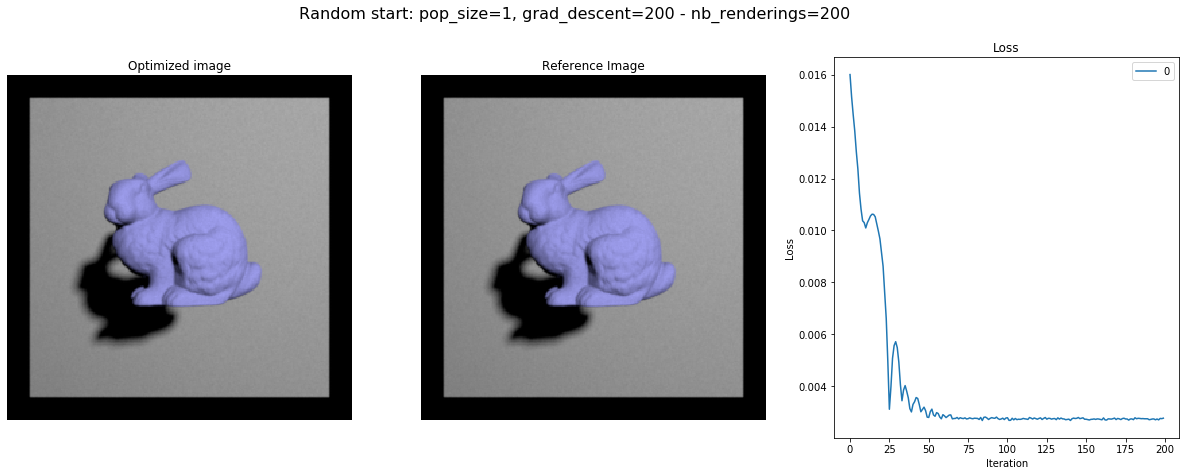

In [9]:
random_start_exp(pop_size=1, grad_steps=200, seed=0)

[Ind. 1/1] Grad step 199	Best loss: 0.008142	Nb renderings: 199: : 1it [00:47, 47.44s/it]


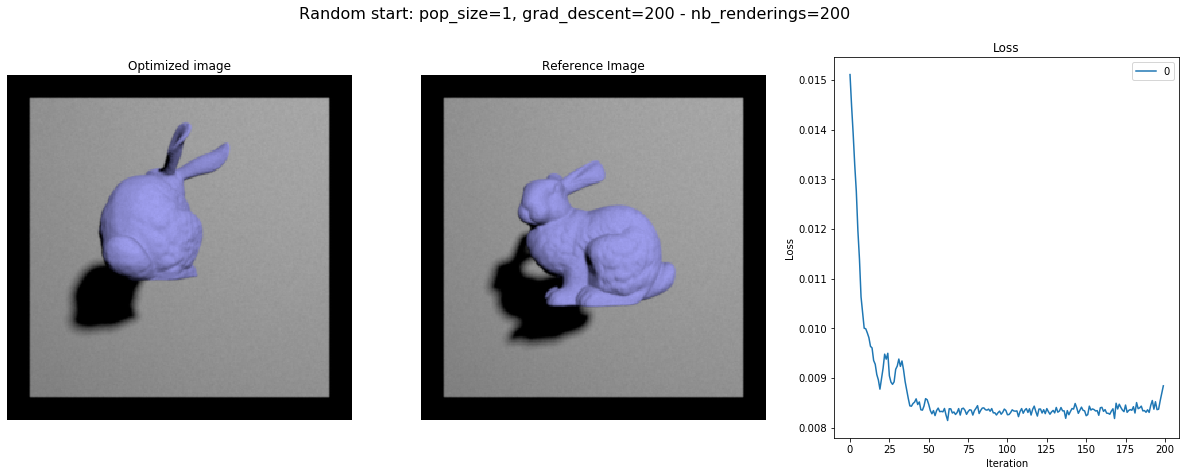

In [10]:
random_start_exp(pop_size=1, grad_steps=200, seed=1)

[Ind. 1/1] Grad step 199	Best loss: 0.015158	Nb renderings: 199: : 1it [00:49, 49.81s/it]


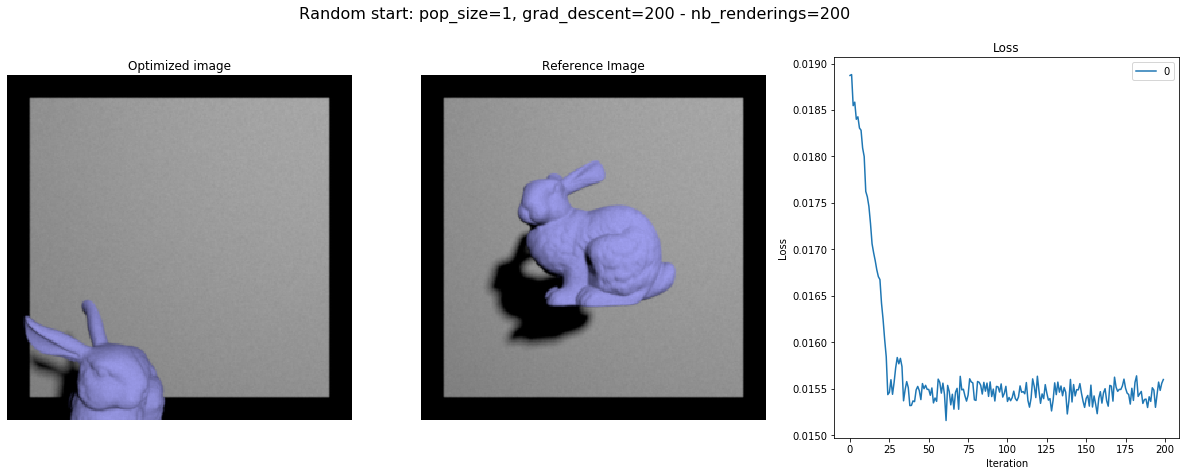

In [11]:
random_start_exp(pop_size=1, grad_steps=200, seed=2)

# Gradient descent from 5 random starting points

[Ind. 5/5] Grad step 39	Best loss: 0.002727	Nb renderings: 199: : 5it [00:51, 10.29s/it]


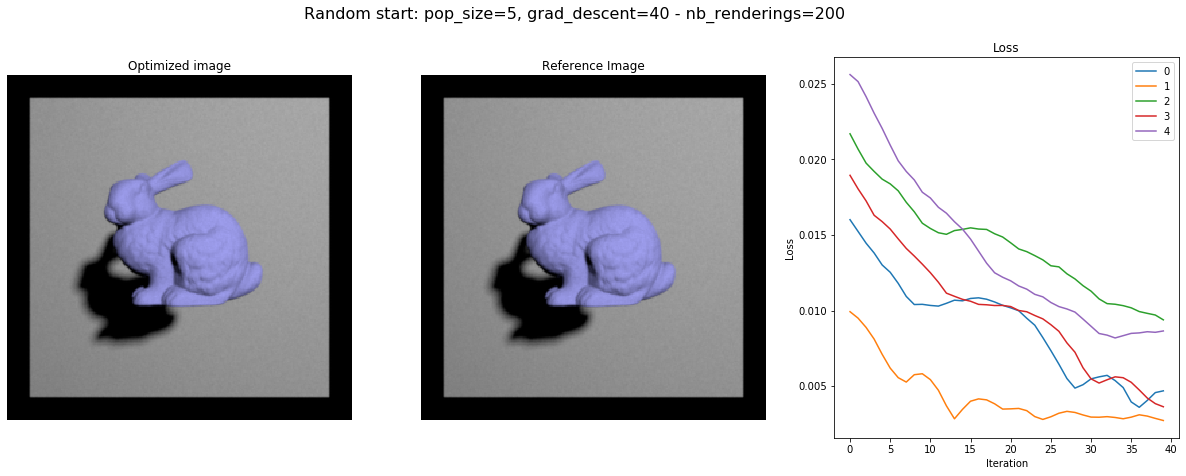

In [12]:
random_start_exp(pop_size=5, grad_steps=40, seed=0)

[Ind. 5/5] Grad step 39	Best loss: 0.004329	Nb renderings: 199: : 5it [00:54, 10.88s/it]


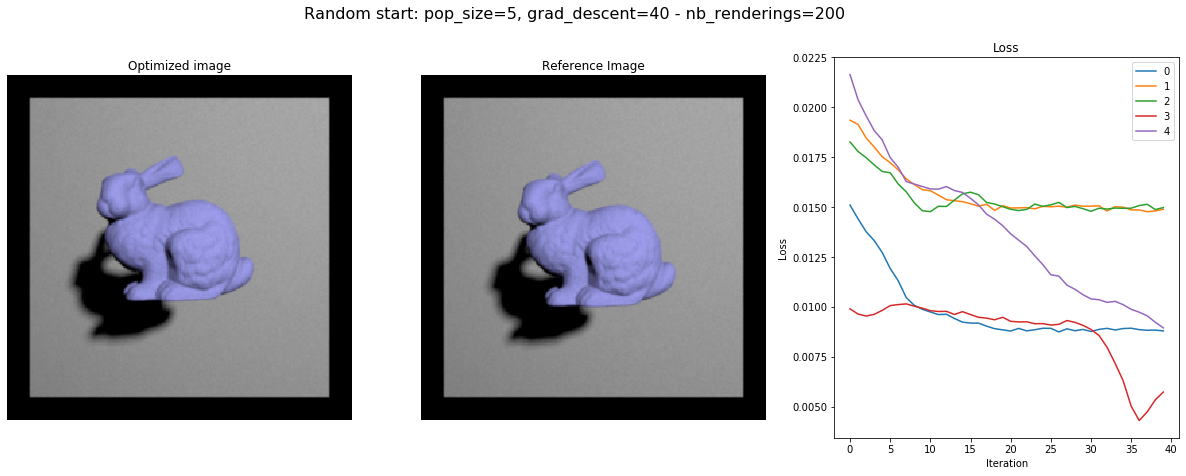

In [13]:
random_start_exp(pop_size=5, grad_steps=40, seed=1)

[Ind. 5/5] Grad step 39	Best loss: 0.002814	Nb renderings: 199: : 5it [00:57, 11.47s/it]


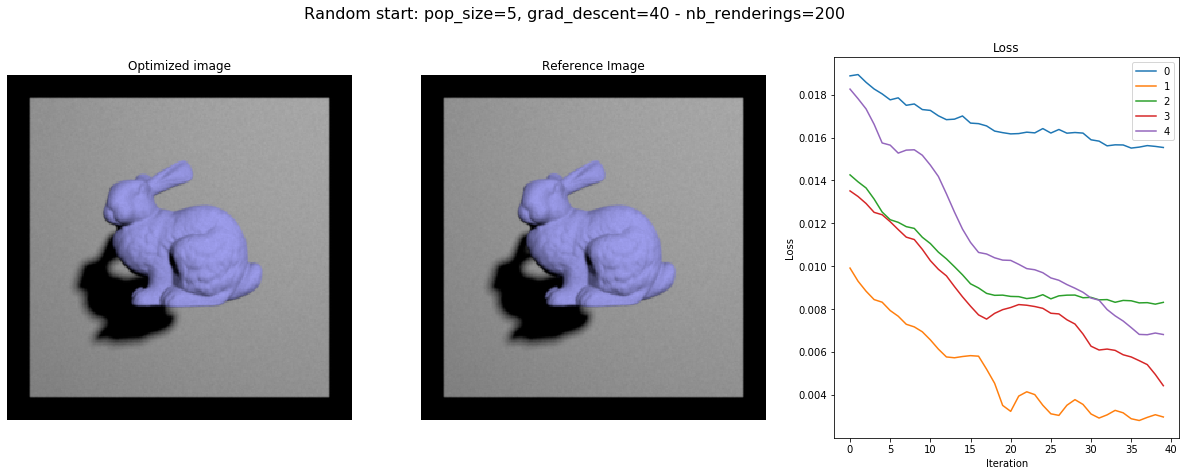

In [14]:
random_start_exp(pop_size=5, grad_steps=40, seed=2)

# Genetic algorithm

[Gen. 10/10] Ind. 20/20	Best loss: 0.002870	Nb renderings: 199: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


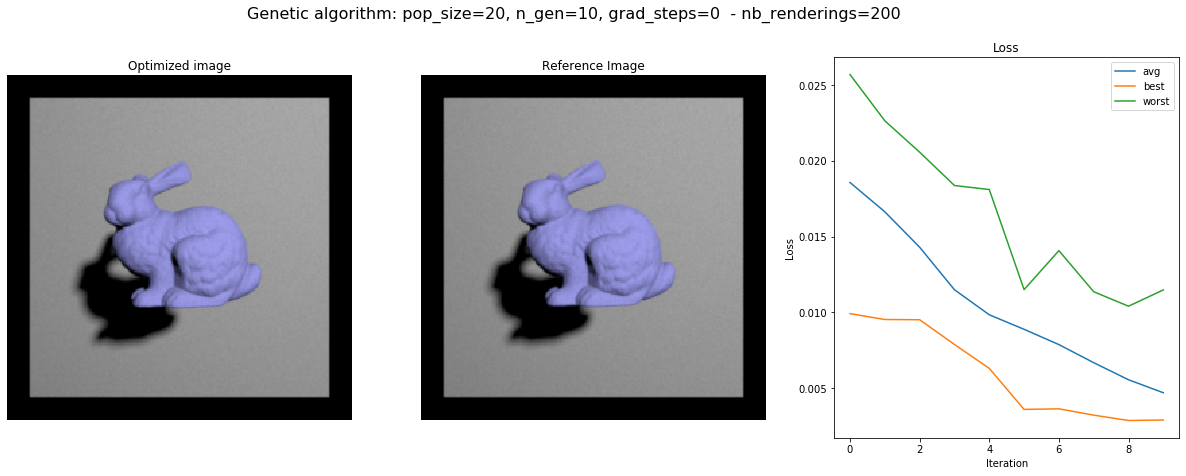

In [19]:
ga_grad_exp(pop_size=20, n_gen=10, grad_steps=0, seed=0)

[Gen. 10/10] Ind. 20/20	Best loss: 0.004147	Nb renderings: 199: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


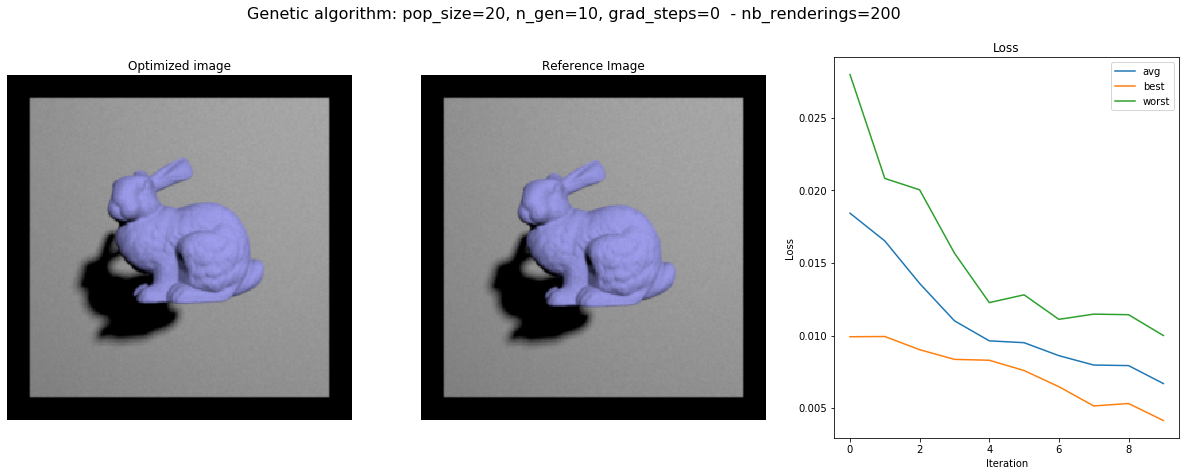

In [20]:
ga_grad_exp(pop_size=20, n_gen=10, grad_steps=0, seed=1)

[Gen. 10/10] Ind. 20/20	Best loss: 0.004579	Nb renderings: 199: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


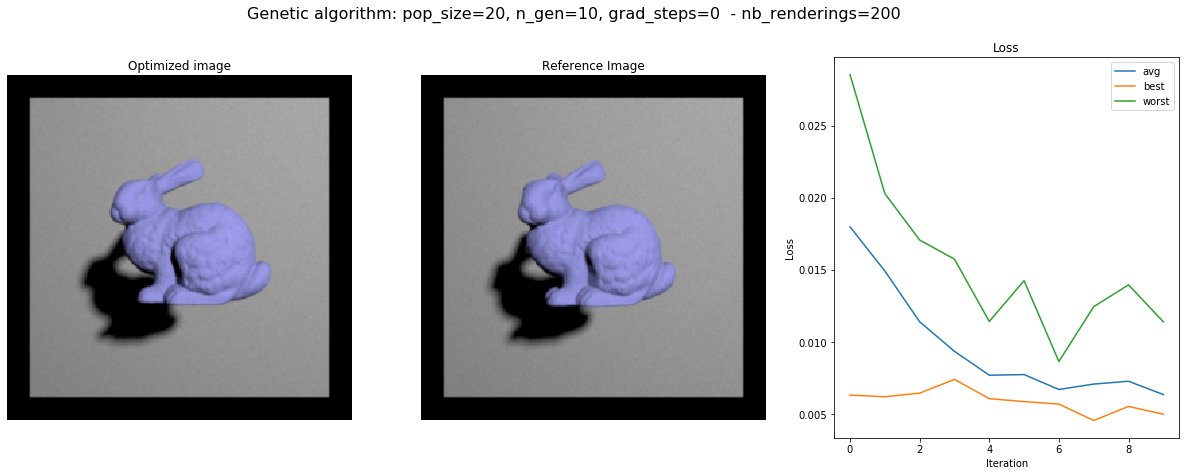

In [21]:
ga_grad_exp(pop_size=20, n_gen=10, grad_steps=0, seed=2)

# Genetic algorithm + gradient descent

[Gen. 4/4] Ind. 10/10	Best loss: 0.002938	Nb renderings: 199: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it]


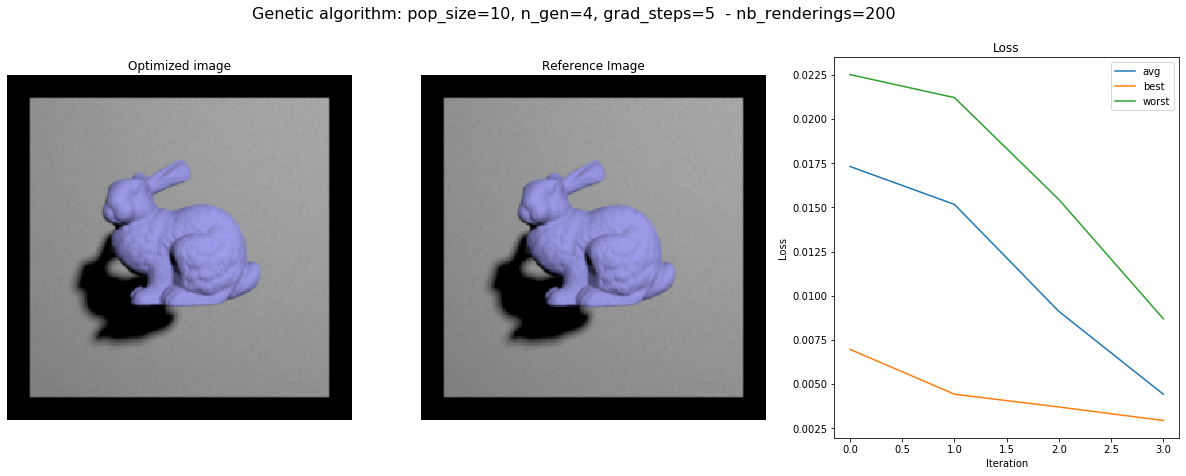

In [22]:
ga_grad_exp(pop_size=10, n_gen=4, grad_steps=5, seed=0)

[Gen. 4/4] Ind. 10/10	Best loss: 0.003172	Nb renderings: 199: 100%|██████████| 4/4 [01:00<00:00, 15.13s/it]


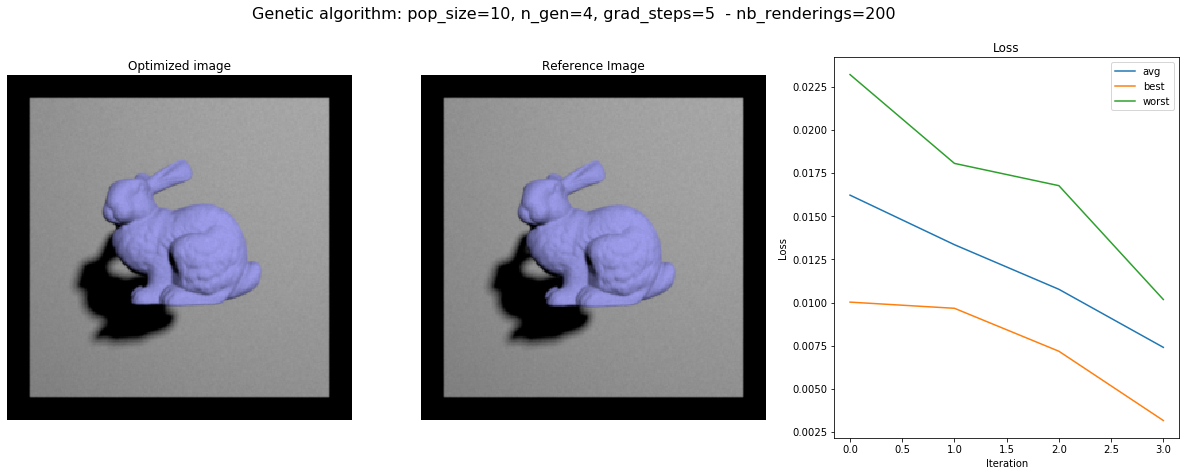

In [23]:
ga_grad_exp(pop_size=10, n_gen=4, grad_steps=5, seed=1)

[Gen. 4/4] Ind. 10/10	Best loss: 0.003017	Nb renderings: 199: 100%|██████████| 4/4 [01:02<00:00, 15.64s/it]


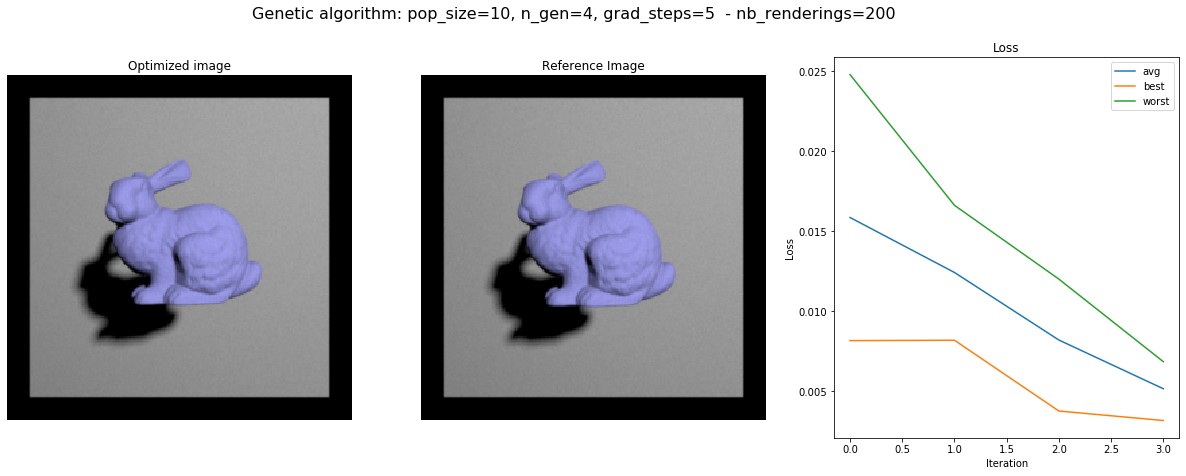

In [24]:
ga_grad_exp(pop_size=10, n_gen=4, grad_steps=5, seed=2)

# BO-Leap

[Step. 1/1 Local step. 2/2 Grad step. 30/30	Best loss: 0.002702	Nb renderings: 100: 100%|██████████| 1/1 [00:31<00:00, 31.06s/it]


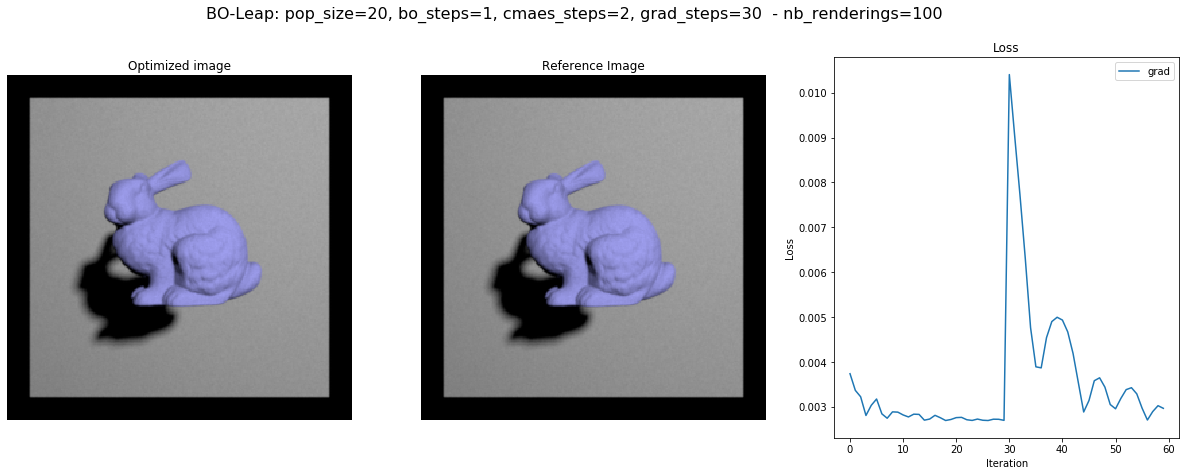

In [25]:
boleap_exp(pop_size=20, bo_steps=1, cmaes_steps=2, grad_steps=30, seed=0)

[Step. 1/1 Local step. 2/2 Grad step. 30/30	Best loss: 0.002695	Nb renderings: 100: 100%|██████████| 1/1 [00:31<00:00, 31.47s/it]


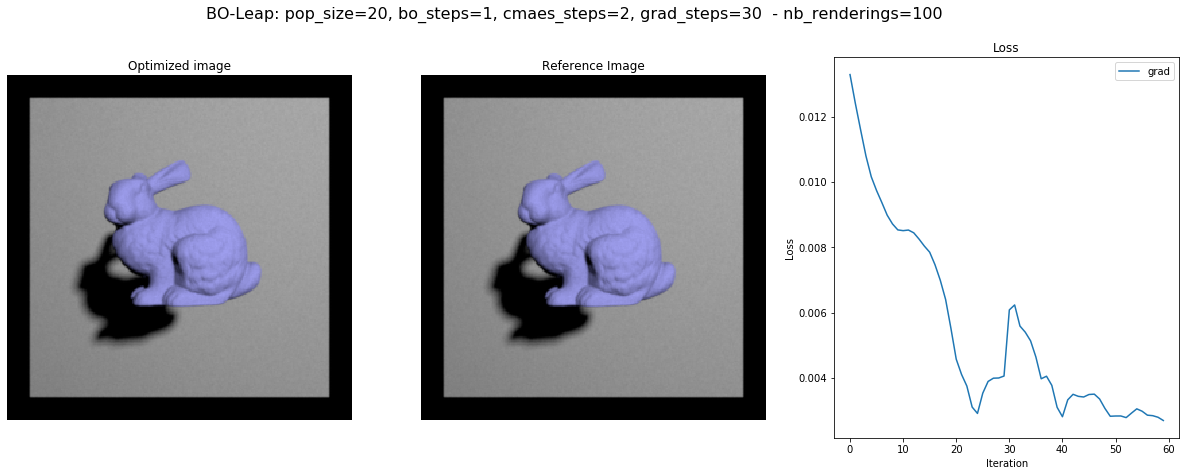

In [26]:
boleap_exp(pop_size=20, bo_steps=1, cmaes_steps=2, grad_steps=30, seed=1)

[Step. 1/1 Local step. 2/2 Grad step. 30/30	Best loss: 0.002848	Nb renderings: 100: 100%|██████████| 1/1 [00:32<00:00, 32.02s/it]


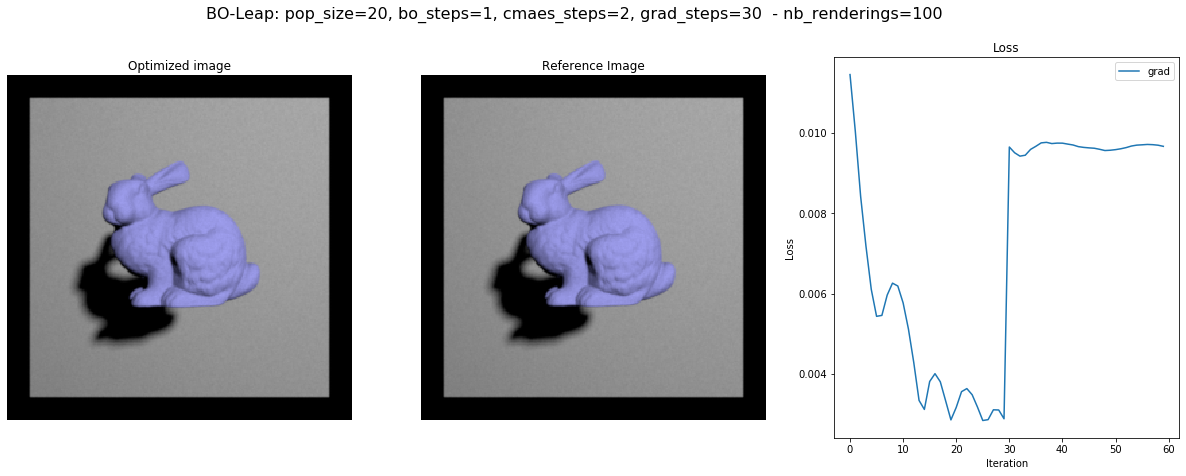

In [27]:
boleap_exp(pop_size=20, bo_steps=1, cmaes_steps=2, grad_steps=30, seed=2)